# CLIP-Conditioned DDPM Training Pipeline

This notebook provides a complete training pipeline for CLIP-conditioned diffusion models. It handles:

1. **Data Preprocessing**: Loading images and extracting CLIP embeddings
2. **Model Configuration**: Using YAML config files for reproducible experiments
3. **Training**: With learning rate scheduling, EMA, and checkpointing
4. **Monitoring**: Loss tracking and sample generation during training

## Quick Start

To train a model:
1. Ensure your dataset is in the correct location (specified in config)
2. Select or create a configuration file in `config/`
3. Run all cells in order
4. Monitor training progress via loss curves and generated samples

For analysis and visualization of trained models, use `explain_and_visualize.ipynb`.

## 1. Setup and Imports

In [1]:
import os
import sys
import random
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
import time
import gc

from ddpm_clip.models import UNet, DDPM, EMA, sample_w
from ddpm_clip.data import CLIPDataset, extract_clip_embeddings
from ddpm_clip.utils import save_animation, generation_image, to_image, load_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CPU not supported, please run on a machine with CUDA"
print(f"Using device: {device}")

Using device: cuda


In [2]:
# OPTIONAL: Set new HOME directory to scratch space for Das6
import getpass

current_user = getpass.getuser()
if current_user == 'ciarella':
    new_home = '/var/scratch/ciarella/xAI'
    os.environ['HOME'] = new_home
    os.makedirs(new_home, exist_ok=True)
    print(f"Changed HOME directory to: {os.environ['HOME']}")
else:
    print(f"Running as user '{current_user}' - using default HOME directory: {os.environ['HOME']}")

Changed HOME directory to: /var/scratch/ciarella/xAI


## 2. Load Configuration

All model parameters are defined in YAML configuration files in the `config/` directory.

**Available configurations:**
- `config/default.yaml` - Basic configuration
- `config/model_v2.yaml` - Improved model with EMA and LR scheduling
- `config/model_large.yaml` - Larger model for better quality

**To create a new configuration:**
1. Copy an existing config file
2. Change the `model_name` field to something unique
3. Adjust hyperparameters as needed
4. Load it here

In [3]:
# MODIFY THIS to use a different configuration
config = load_config('../config/model_small.yaml')

print(f"Loaded configuration for model: {config.model_name}")
print(f"\nKey parameters:")
print(f"  Epochs: {config['training']['epochs']}")
print(f"  Batch size: {config['training']['batch_size']}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Model architecture: {config['model']['down_channels']}")
print(f"  Image size: {config['model']['img_size']}")
print(f"  Diffusion timesteps: {config['diffusion']['timesteps']}")
print(f"  EMA enabled: {config['training']['ema']['enabled']}")
print(f"\nPaths:")
print(f"  Save directory: {config.save_dir}")
print(f"  Checkpoint directory: {config.checkpoint_dir}")

# Create directories
config.create_directories()
print(f"\nDirectories created successfully")

Loaded configuration for model: clip_ddpm_small

Key parameters:
  Epochs: 5
  Batch size: 128
  Learning rate: 0.0002
  Model architecture: [128, 256, 512]
  Image size: 32
  Diffusion timesteps: 300
  EMA enabled: True

Paths:
  Save directory: ../images/clip_ddpm_small
  Checkpoint directory: ../model_checkpoint/clip_ddpm_small
Created directories for model 'clip_ddpm_small':
  Save dir: ../images/clip_ddpm_small
  Checkpoint dir: ../model_checkpoint/clip_ddpm_small

Directories created successfully


## 3. Load CLIP Model

We use CLIP ViT-B/32 to extract 512-dimensional embeddings from images and text.

In [4]:
import clip

gc.collect()
torch.cuda.empty_cache()

clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512
print(f"CLIP model loaded with {CLIP_FEATURES} features")

CLIP model loaded with 512 features


## 4. Dataset Preparation

### 4.1 Collect Image Paths

In [5]:
# Dataset configuration from config file
dataset_root = config['data']['dataset_root']
train_paths = glob.glob(f"{dataset_root}/train/*/images/*.JPEG")
val_paths = glob.glob(f"{dataset_root}/val/images/*.JPEG")
data_paths = train_paths  # Can add validation: train_paths + val_paths

ndata = config['data']['max_samples']
print(f"Found {len(data_paths)} total images")

# Shuffle and limit dataset size
random_seed = config['data']['random_seed']
random.seed(random_seed)

if 'data_paths_shuffled' not in globals():
    print(f"Shuffling data and selecting {ndata} samples...")
    random.shuffle(data_paths)
    data_paths = data_paths[:ndata]
    data_paths_shuffled = True
else:
    print("Data already shuffled, using existing order")

print(f"Using {len(data_paths)} images for training")
print(f"Sample paths: {data_paths[:3]}")

Found 100000 total images
Shuffling data and selecting 50000 samples...
Using 50000 images for training
Sample paths: ['../data/tiny-imagenet-200/train/n02917067/images/n02917067_214.JPEG', '../data/tiny-imagenet-200/train/n03670208/images/n03670208_28.JPEG', '../data/tiny-imagenet-200/train/n01910747/images/n01910747_419.JPEG']


### 4.2 Extract CLIP Embeddings

This is the most computationally expensive preprocessing step. For each image:
1. Load and preprocess the image
2. Pass it through CLIP's image encoder
3. Store the 512-dimensional embedding in a CSV file

**Features:**
- Processes images in batches for efficiency
- Skips already processed images (supports resuming)
- Saves embeddings to CSV for reuse

In [6]:
csv_path = config['data']['clip_csv_path']

# Use the package function to extract CLIP embeddings
num_processed, time_taken = extract_clip_embeddings(
    data_paths,
    clip_model,
    clip_preprocess,
    csv_path,
    device=device,
    batch_size=config['training']['batch_size'],
    skip_existing=True,
    verbose=True
)

print(f"\nCLIP embedding extraction complete!")
print(f"Processed {num_processed} images in {time_taken:.1f}s")
if num_processed > 0:
    print(f"Average rate: {num_processed/time_taken:.1f} images/second")

Found existing CSV file: clip.csv
Found 100000 already processed images
Processing 0 new images (skipping 100000 already done)
All images already processed!

CLIP embedding extraction complete!
Processed 0 images in 0.0s
Found 100000 already processed images
Processing 0 new images (skipping 100000 already done)
All images already processed!

CLIP embedding extraction complete!
Processed 0 images in 0.0s


### 4.3 Define Data Transforms

In [7]:
IMG_CH = config['model']['img_channels']
IMG_SIZE = config['model']['img_size']
BATCH_SIZE = config['training']['batch_size']
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

# Pre-transforms: applied once when loading
pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale to [-1, 1]
])

# Random transforms: applied on-the-fly for data augmentation
random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Image size: 32x32
Batch size: 128


### 4.4 Create Dataset and DataLoader

In [8]:
# Use the CLIPDataset from the package
train_data = CLIPDataset(
    csv_path,
    img_transforms=pre_transforms,
    random_transforms=random_transforms,
    clip_features=CLIP_FEATURES,
    preprocessed_clip=config['data']['preprocessed_clip'],
    device=device
)

dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Dataset size: {len(train_data)} images")
print(f"Number of batches per epoch: {len(dataloader)}")
print(f"Total training samples per epoch: {len(dataloader) * BATCH_SIZE}")

Dataset size: 100000 images
Number of batches per epoch: 781
Total training samples per epoch: 99968


## 5. Model Architecture

### 5.1 Initialize Diffusion Process (DDPM)

In [9]:
T = config['diffusion']['timesteps']
B_start = config['diffusion']['beta_start']
B_end = config['diffusion']['beta_end']
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = DDPM(B, device)

print(f"Diffusion process initialized:")
print(f"  Timesteps: {T}")
print(f"  Beta schedule: {B_start} to {B_end}")

Diffusion process initialized:
  Timesteps: 300
  Beta schedule: 0.0001 to 0.02


### 5.2 Initialize U-Net Model

In [10]:
model = UNet(
    T, IMG_CH, IMG_SIZE,
    down_chs=tuple(config['model']['down_channels']),
    t_embed_dim=config['model']['t_embed_dim'],
    c_embed_dim=config['model']['c_embed_dim']
)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model initialized with {num_params:,} parameters")
print(f"Architecture: {config['model']['down_channels']}")

torch.set_float32_matmul_precision('high')
model_compiled = torch.compile(model.to(device))
print("Model compiled successfully")

Model initialized with 41,171,715 parameters
Architecture: [128, 256, 512]
Model compiled successfully
Model compiled successfully


## 6. Training Setup

### 6.1 Initialize Optimizer and Scheduler

In [11]:
epochs = config['training']['epochs']
c_drop_prob = config['training']['c_drop_prob']
lrate = config['training']['learning_rate']
save_dir = config.save_dir + "/"
checkpoint_path = config.checkpoint_dir

optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

# Learning rate scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=epochs,
    eta_min=config['training']['lr_scheduler']['eta_min']
)

print(f"Training configuration:")
print(f"  Model name: {config.model_name}")
print(f"  Epochs: {epochs}")
print(f"  Learning rate: {lrate}")
print(f"  LR scheduler: CosineAnnealingLR (eta_min={config['training']['lr_scheduler']['eta_min']})")
print(f"  Conditioning drop probability: {c_drop_prob}")
print(f"  Save frequency: every {config['training']['save_frequency']} epochs")

Training configuration:
  Model name: clip_ddpm_small
  Epochs: 5
  Learning rate: 0.0002
  LR scheduler: CosineAnnealingLR (eta_min=2e-06)
  Conditioning drop probability: 0.1
  Save frequency: every 5 epochs


### 6.2 Initialize EMA (Exponential Moving Average)

In [12]:
ema_enabled = config['training']['ema']['enabled']

if ema_enabled:
    ema = EMA(model, decay=config['training']['ema']['decay'])
    print(f"EMA enabled with decay: {config['training']['ema']['decay']}")
else:
    ema = None
    print("EMA disabled")

EMA enabled with decay: 0.999


### 6.3 Load Checkpoint (if resuming training)

In [13]:
start_epoch = 0
loss_history = []

if os.path.exists(checkpoint_path):
    checkpoint_files = [f for f in os.listdir(checkpoint_path) if f.endswith('.pth')]
    if checkpoint_files:
        latest_epoch = max([int(f.split('.')[0]) for f in checkpoint_files])
        latest_checkpoint = os.path.join(checkpoint_path, f"{latest_epoch}.pth")
        checkpoint = torch.load(latest_checkpoint, map_location=device)
        
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        
        if ema_enabled and 'ema' in checkpoint:
            ema.shadow = checkpoint['ema']
        
        start_epoch = checkpoint['epoch'] + 1
        
        if 'loss_history' in checkpoint:
            loss_history = checkpoint['loss_history']
            print(f"Resumed from epoch {start_epoch} with {len(loss_history)} loss values in history")
        else:
            print(f"Resumed from epoch {start_epoch} (no loss history in checkpoint)")
else:
    print("No checkpoint found - starting fresh training")

if start_epoch >= epochs:
    print(f"\nWARNING: Already trained to epoch {epochs}. Increase epochs in config to continue training.")

## 7. Training Loop

This cell performs the main training loop with:
- Average loss tracking per epoch
- Learning rate scheduling
- EMA weight updates
- Periodic checkpointing and sample generation
- Time estimation

In [14]:
if start_epoch < epochs:
    model.train()
    
    save_freq = config['training']['save_frequency']
    epoch_times = []
    
    print(f"\nStarting training from epoch {start_epoch} to {epochs-1}")
    print(f"{'='*80}\n")
    
    for epoch in range(start_epoch, epochs):
        epoch_start_time = time.time()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        # Track average loss per epoch
        epoch_losses = []
        
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x, c = batch
            c_mask = ddpm.get_context_mask(c, c_drop_prob)
            loss = ddpm.get_loss(model_compiled, x, t, c, c_mask)
            loss.backward()
            optimizer.step()
            
            # Update EMA after each step
            if ema_enabled:
                ema.update()
            
            epoch_losses.append(loss.item())
        
        # Step the learning rate scheduler
        scheduler.step()
        
        # Calculate epoch time and statistics
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        avg_epoch_time = np.mean(epoch_times)
        
        avg_loss = np.mean(epoch_losses)
        loss_history.append(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Estimate remaining time
        remaining_epochs = epochs - epoch - 1
        eta_seconds = remaining_epochs * avg_epoch_time
        eta_mins = eta_seconds / 60
        
        print(f"Epoch {epoch:3d}/{epochs-1} | "
              f"Loss: {avg_loss:.6f} | "
              f"LR: {current_lr:.2e} | "
              f"Time: {epoch_time:.1f}s | "
              f"ETA: {eta_mins:.1f}m")
        
        # Save checkpoint and generate samples
        if epoch % save_freq == 0 or epoch == int(epochs - 1):
            print(f"  → Saving checkpoint and generating samples...")
            
            # Save checkpoint
            checkpoint_data = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'epoch': epoch,
                'loss_history': loss_history,
                'config': config.to_dict()
            }
            if ema_enabled:
                checkpoint_data['ema'] = ema.shadow
            
            torch.save(checkpoint_data, f"{checkpoint_path}/{epoch}.pth")
            
            # Use EMA weights for generation if enabled
            if ema_enabled:
                ema.apply_shadow()
            model.eval()
            
            # Generate samples
            text_list = config['generation']['text_prompts']
            w_list = config['generation']['guidance_weights']
            
            text_tokens = clip.tokenize(text_list).to(device)
            c = clip_model.encode_text(text_tokens).float()
            x_gen, x_gen_store = sample_w(model, ddpm, INPUT_SIZE, T, c, device, w_tests=w_list)
            generation_image(x_gen, text_list, w=w_list, save_path=save_dir+f"image_ep{epoch:03d}.png")
            
            # Restore training weights if using EMA
            if ema_enabled:
                ema.restore()
            model.train()
    
    print(f"\n{'='*80}")
    print(f"Training completed!")
    print(f"  Final average loss: {loss_history[-1]:.6f}")
    print(f"  Total training time: {sum(epoch_times)/60:.2f} minutes")
    print(f"  Average time per epoch: {avg_epoch_time:.2f}s")
else:
    print("Training already complete. To continue training, increase 'epochs' in config.")


Starting training from epoch 0 to 4

Epoch   0/4 | Loss: 0.096948 | LR: 1.81e-04 | Time: 180.5s | ETA: 12.0m
  → Saving checkpoint and generating samples...
Epoch   0/4 | Loss: 0.096948 | LR: 1.81e-04 | Time: 180.5s | ETA: 12.0m
  → Saving checkpoint and generating samples...
Figure saved to: ../images/clip_ddpm_small/image_ep000.png
Figure saved to: ../images/clip_ddpm_small/image_ep000.png
Epoch   1/4 | Loss: 0.067654 | LR: 1.32e-04 | Time: 153.1s | ETA: 8.3m
Epoch   1/4 | Loss: 0.067654 | LR: 1.32e-04 | Time: 153.1s | ETA: 8.3m


KeyboardInterrupt: 

## 8. Training Analysis

### 8.1 Plot Training Loss Curve

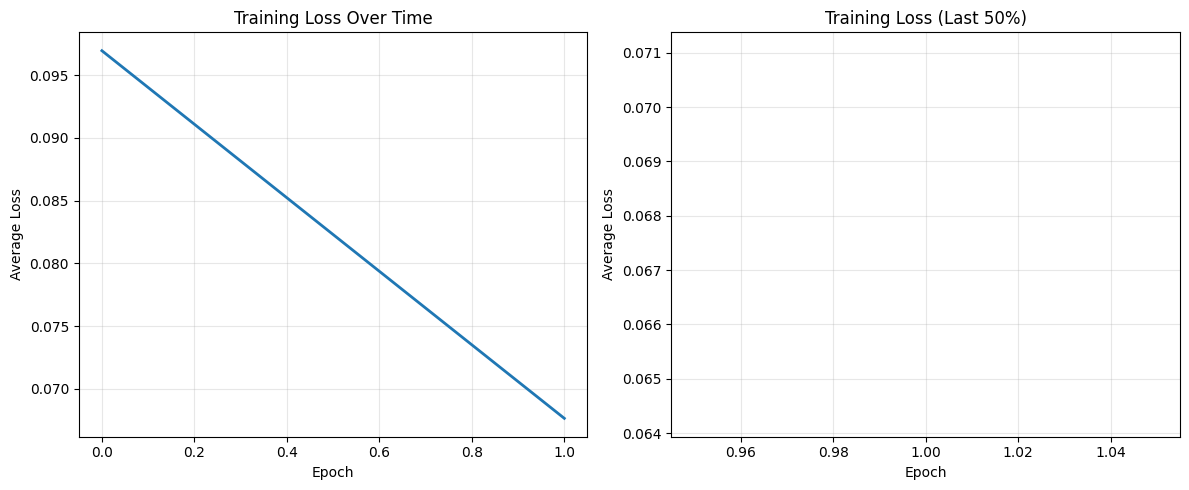

Best loss: 0.067654 at epoch 1
Final loss: 0.067654


In [15]:
if len(loss_history) > 0:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss_history)), loss_history, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Time')
    plt.grid(True, alpha=0.3)
    
    # Plot last 50% of training to see recent trends
    plt.subplot(1, 2, 2)
    start_idx = len(loss_history) // 2
    plt.plot(range(start_idx, len(loss_history)), loss_history[start_idx:], linewidth=2, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss (Last 50%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/loss_curve.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Best loss: {min(loss_history):.6f} at epoch {np.argmin(loss_history)}")
    print(f"Final loss: {loss_history[-1]:.6f}")
else:
    print("No loss history available")

### 8.2 Generate Final Samples with EMA Weights

In [16]:
# Apply EMA weights for final generation if enabled
if ema_enabled and ema is not None:
    ema.apply_shadow()
model.eval()

text_list = config['generation']['text_prompts']
w_values = config['generation']['guidance_weights']

text_tokens = clip.tokenize(text_list).to(device)
c = clip_model.encode_text(text_tokens).float()
x_gen, x_gen_store = sample_w(model, ddpm, INPUT_SIZE, T, c, device, w_tests=w_values)

fig = generation_image(x_gen, text_list, w=w_values, save_path=save_dir+"final_generation_ema.png")
plt.show()

print(f"Final generation saved to: {save_dir}final_generation_ema.png")

# Restore for future training if using EMA
if ema_enabled and ema is not None:
    ema.restore()

Figure saved to: ../images/clip_ddpm_small/final_generation_ema.png
Final generation saved to: ../images/clip_ddpm_small/final_generation_ema.png


### 8.3 Create Animation of Generation Process

In [17]:
# Generate animation with EMA weights if enabled
if ema_enabled and ema is not None:
    ema.apply_shadow()
model.eval()

grids = [generation_image(x_gen.cpu(), text_list, w=w_values) for x_gen in x_gen_store]
save_animation(grids, save_dir+"generation_ema.gif")
print(f"Animation saved to: {save_dir}generation_ema.gif")

if ema_enabled and ema is not None:
    ema.restore()

Animation saved to: ../images/clip_ddpm_small/generation_ema.gif
Animation saved to: ../images/clip_ddpm_small/generation_ema.gif


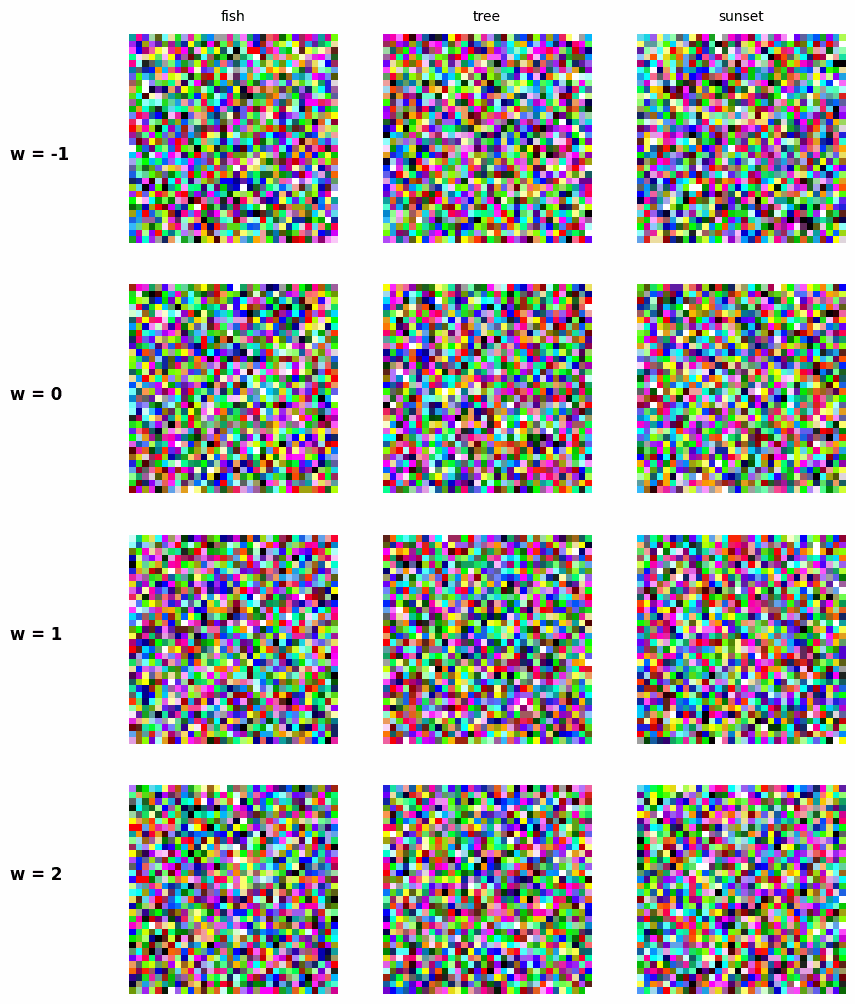

In [18]:
from IPython.display import Image as IPImage, display
display(IPImage(filename=save_dir+"generation_ema.gif"))

## 9. Summary

### Training Complete! 🎉

Your model has been successfully trained and saved. Here's what was created:

**Saved Files:**
- Model checkpoints: `{checkpoint_path}/*.pth`
- Training samples: `{save_dir}/image_ep*.png`
- Final generation: `{save_dir}/final_generation_ema.png`
- Generation animation: `{save_dir}/generation_ema.gif`
- Loss curve: `{save_dir}/loss_curve.png`

**Next Steps:**

1. **Analyze your model**: Use `explain_and_visualize.ipynb` to:
   - Load this trained model
   - Visualize the denoising process
   - Analyze noise patterns and guidance effects
   - Generate images with custom prompts

2. **Experiment with configurations**: Create a new config file to try:
   - Different model architectures (larger/smaller)
   - Different training hyperparameters
   - Different diffusion schedules

3. **Train on more data**: Increase `max_samples` in config for better quality

4. **Continue training**: Increase `epochs` in config and re-run the training cell
